# Build a news Q&A RAG agent with Pinecone vectorDB + AP News articles

Let's build an up-to-date Q&A agent with a RAG as follows:
1. collect a "large" corpus of documents by grabbing a bunch of AP/Reuters news articles 
2. index with OpenAI "text-embedding-3-small"
3. store in a Pinecone vectorDB for efficient and scalable retrieval
4. answer a few questions about this week's news

In [1]:
import getpass
import os

from pinecone import Pinecone

pinecone_api_key = os.environ['PINECONE_API_KEY']

pc = Pinecone(api_key=pinecone_api_key)

In [2]:
print(len(os.environ["LANGSMITH_API_KEY"]))
os.environ["LANGSMITH_TRACING"] = "true"

51


In [3]:
from pinecone import ServerlessSpec

index_name = "langchain-news-index"  # change if desired

if pc.has_index(index_name):
    print(f"Index '{index_name}' already exists. Deleting it...")
    pc.delete_index(index_name)
    print(f"Index '{index_name}' deleted.")

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

index = pc.Index(index_name)

Index 'langchain-news-index' already exists. Deleting it...
Index 'langchain-news-index' deleted.


In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [5]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [6]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://apnews.com/article/democrats-party-message-new-york-virginia-jersey-854a42881ccfe3bfefe31b15b8f0e504?_gl=1*7ce9tm*_up*MQ..*_gs*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/mamdani-new-york-london-mayor-sadiq-khan-918667094240586ee121bff306c8d111?_gl=1*92s1rk*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/virginia-election-jay-jones-hashmi-abigail-spanberger-e29284ca7020cb9dbcf3adfdf2170a96?_gl=1*1kgr5yr*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/video/donald-trump-booed-as-the-1st-sitting-us-president-at-a-regular-season-nfl-game-nearly-a-half-century-e6f6b873e0024f2aa52bff2e1e942dab?_gl=1*1n6fark*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/stocks-markets-ai-earnings-trump-f2bee27796f9401e5cd8d88c06785f93?_gl=1*g8qge6*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/consumer-sentiment-umich-shutdown-ec39997fc6dce4e41976a644d8f4f542?_gl=1*1slmwcq*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/2026-election-utility-bills-ai-data-centers-13703f61d1397612fd067e69b9093116?_gl=1*12vcy1*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/hub/inflation?_gl=1*45lvri*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/national-retail-federation-holiday-forecast-tariffs-inflation-de5b851a009fed78b446676c1d944853?_gl=1*1qhnho0*_up*MQ..&gclid=CjwKCAiAt8bIBhBpEiwAzH1w6cejPTgy1uhVGCvtQXHWY6BvryQx8gNyJW7Xs4dYVuaQRYGqpqRatxoC32UQAvD_BwE&gbraid=0AAAAAC5L6PBXc659y0jyNnb1rN4Tbr_ie",
    "https://apnews.com/article/government-shutdown-congress-trump-641e7e2324f261da72395b604d9540e8", 
    "https://apnews.com/article/snap-benefits-trump-administration-demands-undo-states-d433f20df4d461db506e0d327a58d3c1", 
    "https://apnews.com/article/government-shutdown-longest-trump-republican-senators-democrats-9712df6c11ef19c5df8f18c8a4f7b341", 
    "https://apnews.com/article/virginia-new-jersey-trump-election-democrat-republican-fad109893cfd4be5b49a5bb1b0138d8d", 
    "https://apnews.com/article/longest-government-shutdown-trump-schumer-elections-183a80e0bb9ab6a2ee6ddd5e8367f100", 
    "https://apnews.com/article/government-shutdown-democrats-trump-election-senate-2079f4008c87aeb71d2f3998c3c42901", 
    "https://apnews.com/article/economy-issues-exit-poll-election-2025-ccd2cab49e6f7d6b310173d70ce570f8", 
    "https://apnews.com/article/trump-administration-renews-supreme-court-appeal-snap-c633d646f08f395e7d157d1145eaf727", 
    "https://apnews.com/article/britain-bbc-crisis-trump-panorama-a392fb275af25216ea23537c6f4347e4", 
    "https://apnews.com/us-news", 
    "https://apnews.com/hub/ap-top-news",
    "https://www.reuters.com/world/us/us-senate-compromise-sets-stage-end-government-shutdown-2025-11-10/",
    "https://www.reuters.com/world/us/whats-deal-end-longest-us-government-shutdown-2025-11-10/",
    "https://www.reuters.com/business/healthcare-pharmaceuticals/trump-takes-aim-obamacare-historic-federal-shutdown-hits-40th-day-2025-11-09/",
    
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
for i,doc in enumerate(docs[:5]):
    print(f'document {i}, start = "{doc[0].page_content.strip()[:35]}", num_chars={len(doc[0].page_content.strip())}')

document 0, start = "Democrats are hopeful but questions", num_chars=59057
document 1, start = "London's Sadiq Khan and NYC Mayor-e", num_chars=58335
document 2, start = "Virginia voters elect barrier-break", num_chars=56650
document 3, start = "Trump booed as the first sitting US", num_chars=53621
document 4, start = "Rallies for Nvidia and Big Tech hel", num_chars=54681


In [8]:
import re
def clean_docs(docs):
    for doc in docs:
        # Replace multiple newlines with a single newline (paragraph break)
        doc.page_content = re.sub(r'\n{2,}', ' ', doc.page_content)
        # Optional: Replace remaining single newlines with a space to merge lines into paragraphs
        # cleaned_content = re.sub(r'\n', ' ', cleaned_content) 
        # Optional: Replace multiple spaces with a single space and strip leading/trailing whitespace
        doc.page_content = re.sub(r' +', ' ', doc.page_content).strip()
    return docs

docs_list = [item for sublist in docs for item in sublist]
docs_list = clean_docs(docs_list)

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=256, chunk_overlap=50
)
documents = text_splitter.split_documents(docs_list)

In [10]:
from uuid import uuid4

uuids = [str(uuid4()) for _ in range(len(documents))]
vector_store.add_documents(documents=documents, ids=uuids)

['ce2cc85b-ddb7-48fc-ae94-5711285e3dd0',
 'ca3197f1-9088-439d-a034-05b2920f45fa',
 'f41f91c0-31cc-41ba-87ad-df1d32a6d745',
 '7059e563-7fed-494f-b438-a22857463d05',
 'd230f76a-a16b-464e-adf4-8e7bec1f7f93',
 '387ce68f-6788-4970-80d4-5c604fedb1f8',
 '35d307f9-9890-4510-bf2c-369d6dd57b18',
 'ee0c5047-1c57-4368-8c3c-c6845a139abd',
 '1aac82b5-fa6c-4ae0-9be1-2b96dde39312',
 'b4ef6967-3e84-491e-9a4d-ffbaa8151ec9',
 'b91d3699-ec60-4dc8-bc62-345eefa2c3bc',
 '13b77d76-f486-465f-9085-3fdf8b71b8e5',
 '4da28009-9a33-4cb3-b7df-498bc6c96873',
 '8fd27d7f-8c34-4896-b6ae-aa8372882133',
 '677edda3-8fb9-41aa-8e59-8d1a12f43f69',
 '91e16086-ecbe-4665-a85e-c29669e8b03c',
 '4026fd5f-c3ea-4552-8853-9fe72450b12c',
 'f73600f7-d540-4c95-a665-2031e4d84a07',
 '63ca4ffa-a0de-4a5b-9022-43d5c36242dc',
 'df9770be-652f-42ae-b6ee-945b42a4bbab',
 'a7886bea-874c-44cf-8b01-19784f95dc48',
 'e8387214-e496-4bbf-ae77-a31980af030b',
 'db764d33-677c-448e-87fe-b86c3e3ba91a',
 'a6933a7d-d15b-4257-ba79-8e33ce789ba5',
 '33deeae4-3e5d-

In [11]:
print(f'number of indexed chunks: {len(uuids)}')

number of indexed chunks: 1059


### inspect the top results for a particular query

In [12]:
results = vector_store.similarity_search(
    "what's happening with the government shutdown?",
    k=2,
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]\n")

* X LinkedIn Bluesky Flipboard Pinterest Reddit WASHINGTON (AP) — Talks intensified Tuesday toward a potential end to the government shutdown, as the federal closure was on track to become the longest ever, disrupting the lives of millions of Americans. But tensions also rose as senators from both parties, Republicans and Democrats, quietly negotiated the contours of an emerging deal. With a nod from their leadership, the senators are seeking a way to reopen the government, put the normal federal funding process back on track and devise some sort of resolution for expiring health insurance subsidies that are spiking premium costs from coast to coast.“Enough is enough,” said Senate Majority Leader John Thune, the South Dakota Republican, as he opened the deadlocked chamber. On day 35 of the federal government shutdown, the record for the longest will be broken after midnight. SNAP benefits have been interrupted for millions of Americans depending on federal food aid and hundreds of thou

In [13]:
results = vector_store.similarity_search_with_score(
    "what's happening with the government shutdown?", 
    k=2,
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=0.647709] X LinkedIn Bluesky Flipboard Pinterest Reddit WASHINGTON (AP) — Talks intensified Tuesday toward a potential end to the government shutdown, as the federal closure was on track to become the longest ever, disrupting the lives of millions of Americans. But tensions also rose as senators from both parties, Republicans and Democrats, quietly negotiated the contours of an emerging deal. With a nod from their leadership, the senators are seeking a way to reopen the government, put the normal federal funding process back on track and devise some sort of resolution for expiring health insurance subsidies that are spiking premium costs from coast to coast.“Enough is enough,” said Senate Majority Leader John Thune, the South Dakota Republican, as he opened the deadlocked chamber. On day 35 of the federal government shutdown, the record for the longest will be broken after midnight. SNAP benefits have been interrupted for millions of Americans depending on federal food aid and h

In [14]:
from langchain_classic.tools.retriever import create_retriever_tool
retriever = vector_store.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_news_articles",
    "Search and return information about recent news articles.",
)

In [15]:
retriever_tool.invoke({"query": "what is happening with the shutdown?"})

'X LinkedIn Bluesky Flipboard Pinterest Reddit WASHINGTON (AP) — Talks intensified Tuesday toward a potential end to the government shutdown, as the federal closure was on track to become the longest ever, disrupting the lives of millions of Americans. But tensions also rose as senators from both parties, Republicans and Democrats, quietly negotiated the contours of an emerging deal. With a nod from their leadership, the senators are seeking a way to reopen the government, put the normal federal funding process back on track and devise some sort of resolution for expiring health insurance subsidies that are spiking premium costs from coast to coast.“Enough is enough,” said Senate Majority Leader John Thune, the South Dakota Republican, as he opened the deadlocked chamber. On day 35 of the federal government shutdown, the record for the longest will be broken after midnight. SNAP benefits have been interrupted for millions of Americans depending on federal food aid and hundreds of thous

In [16]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [17]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [18]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "what's happening with the government shutdown?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_news_articles (call_ZgKFFy1J6ySgjzE1veHeElCh)
 Call ID: call_ZgKFFy1J6ySgjzE1veHeElCh
  Args:
    query: government shutdown


In [19]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gpt-4o", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [20]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [22]:
from langchain_core.messages import convert_to_messages
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "what's happening with the government shutdown?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_news_articles",
                        "args": {"query": "government shutdown"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What is the current status of the government shutdown and its potential impact?


In [23]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

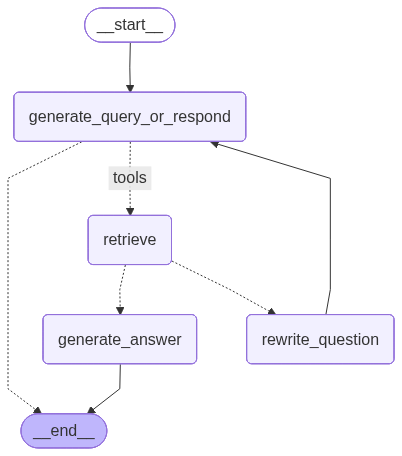

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is happening with the government shutdown?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_news_articles (call_1P2QFXse1BWDIXMYCgm7Y64q)
 Call ID: call_1P2QFXse1BWDIXMYCgm7Y64q
  Args:
    query: government shutdown



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_news_articles

X LinkedIn Bluesky Flipboard Pinterest Reddit WASHINGTON (AP) — Talks intensified Tuesday toward a potential end to the government shutdown, as the federal closure was on track to become the longest ever, disrupting the lives of millions of Americans. But tensions also rose as senators from both parties, Republicans and Democrats, quietly negotiated the contours of an emerging deal. With a nod from their leadership, the senators are seeking a way to reopen the government, put the normal federal funding process back on track and devise some sort of resolution for expiring health ins

In [28]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is happening with the market?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_news_articles (call_Tr1IGWVlbCU4QxajlqxxQa72)
 Call ID: call_Tr1IGWVlbCU4QxajlqxxQa72
  Args:
    query: stock market news



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_news_articles

More news

X LinkedIn Bluesky Flipboard Pinterest Reddit NEW YORK (AP) — Big Tech and other superstars of the U.S. stock market got back to rallying on Monday, and Wall Street recovered most of its loss from last week.The S&P 500 climbed 1.5% and clawed back nearly all its drop from last week, which was its first weekly loss in four. The Dow Jones Industrial Average rose 381 points, or 0.8%, and the Nasdaq composite jumped 2.3% for its best day since May. Nvidia was by far the strongest force lifting the market and leaped 5.8%. It was a powerful rebound after Nvidia and other winners